<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/dev3/src/acoustic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os

zip_filename = 'vs_release_16k.zip'

if not os.path.exists(zip_filename):
    os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [4]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

Ahora pasamos los datos a numpy arrays para poder trabajar con ellos:

In [10]:
import os
import wave
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

def read_wav_file(wav_file):
    wave_name = os.path.basename(wav_file)
    wave_name = os.path.splitext(wave_name)[0]

    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)

    wave_array = np.frombuffer(frames, dtype=np.int16)

    return wave_name, wave_array, num_frames

audio_dir = 'audio_16k/'

if not 'df' in globals():
  audios = os.listdir(audio_dir)
  audio_paths = [os.path.join(audio_dir, file) for file in audios]

  with ThreadPoolExecutor() as exe:
      df = pd.DataFrame(exe.map(read_wav_file, audio_paths), columns=['id', 'signal', 'frames'])

df.head()

,id,signal,frames
0,m1095_0_cough,"[-1, 1, 0, -1, 0, -1, -1, 1, 0, -1, -1, -2, -1...",58709
1,f3183_0_sneeze,"[9, 16, 15, 18, 16, 16, 16, 15, 12, 10, 10, 9,...",49152
2,m3193_0_cough,"[6, 0, 3, -6, -18, -11, -11, -6, 0, 2, 12, 25,...",47787
3,m3194_0_sniff,"[-14, -27, -30, -30, -27, -35, 12, 64, 9, -48,...",105131
4,m0440_0_sneeze,"[2, 1, 0, 3, 6, 1, 0, 1, 0, -3, -7, -2, 0, -3,...",53248


Observación: Nuestros threads acceden a elementos distintos por tanto no hay problemas de race condition.

Mostramos un resultado con matplotlib:

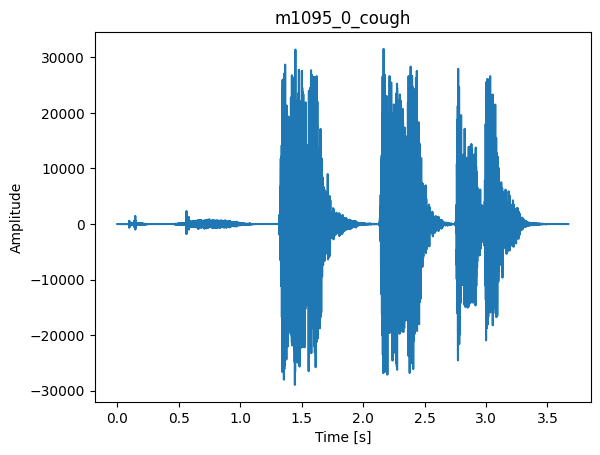

In [11]:
import matplotlib.pyplot as plt

name, signal, frames = df.iloc[0]

sample_rate = 16_000
duration = frames / sample_rate

x = np.linspace(0, duration, frames)
y = signal

plt.plot(x, y)
plt.title(name)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

Los nombres del archivo presentan una estructura:  
[sex] [id] \_ [index] \_ [class]  

- sex: m(male), f(female), o(other)  
- id: identificador del sujeto  
- index: índice, para un sujeto se puede tener más de una observación de la clase (class)  
(Ejemplo: si un sujeto tiene dos cough asociadas tendrán índices 0 y 1)  
- class: sonido vocal reproducido  
    - cough  
    - sniff  
    - sneeze  
    - sigh  
    - laughter  
    - throatclearing  

Crearemos nuevas columnas a partir de esta identificación de audio:

In [ ]:
import re

pattern = r'([mfo])(\d+)_(\d+)_(\w+)'

def extract_info(string):
    match = re.match(pattern, string)

    sex = match.group(1)
    id = match.group(2)
    index = match.group(3)
    label = match.group(4)

    return pd.Series([sex, id, index, label])

df_std = df.copy()
df_std[['sex', 'id', 'index', 'label']] = df_std['id'].apply(extract_info)
df_std.head()

,id,signal,frames,sex,index,label
0,0003,"[38, 53, 50, 49, -6, -15, -26, -32, -6, -1, 36...",66873,f,0,cough
1,0003,"[-29, 71, 161, 211, 192, 49, -13, -173, -207, ...",72818,f,0,laughter
2,0003,"[15, 49, 19, 22, -14, -19, 13, -13, 24, 12, 24...",56471,f,0,sigh
3,0003,"[49, 16, -69, 146, -76, 132, -22, 86, 66, 6, 6...",54985,f,0,sneeze
4,0003,"[-37, -64, -58, -72, -70, -68, -66, -70, -68, ...",54985,f,0,sniff


Tenemos 3504 observaciones de cada clase

In [ ]:
df_std.groupby('label').size().to_frame(name='count')

,count
label,
cough,3504
laughter,3504
sigh,3504
sneeze,3504
sniff,3504
throatclearing,3504


Podemos también comprobar de media

In [ ]:
sample_rate = 16_000
avg_length = df_std.groupby('label')['frames'].mean()
pd.DataFrame({'avg_length(seconds)': avg_length / sample_rate})

,avg_length(seconds)
label,
cough,4.571497
laughter,4.233145
sigh,4.562301
sneeze,3.848751
sniff,3.983074
throatclearing,3.843606


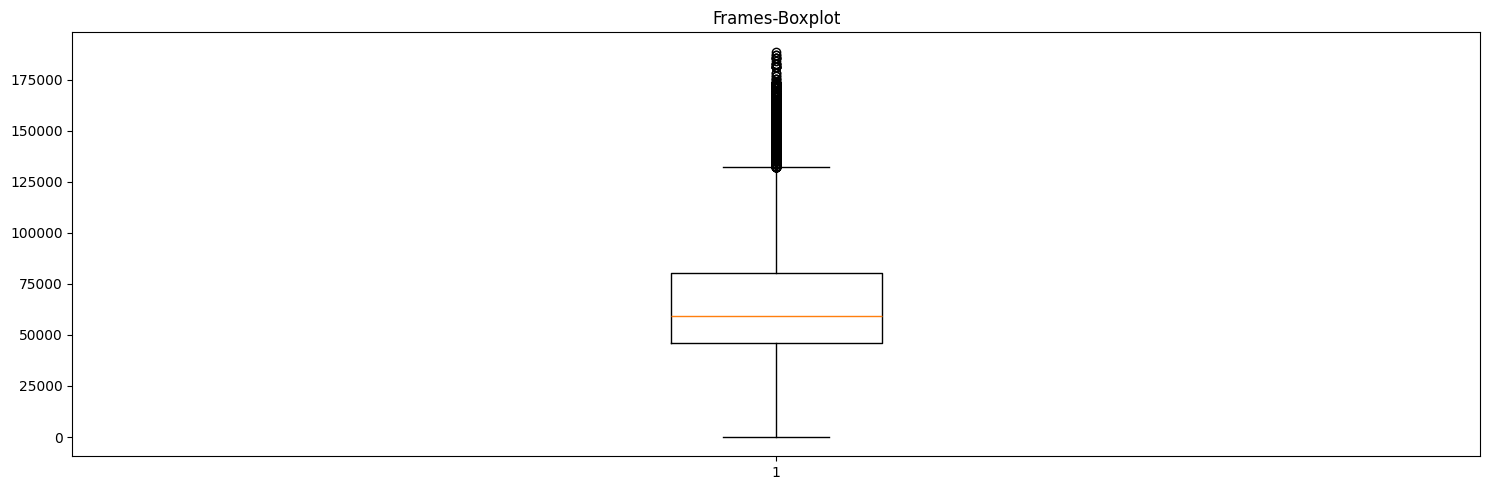

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))

axs.boxplot(df_std['frames'])
axs.set_title('Frames-Boxplot')

plt.tight_layout()
plt.show()

In [ ]:
max_len = df_std['frames'].max()
min_len = df_std['frames'].min()
mean_len = df_std['frames'].mean()
max_len, min_len, mean_len

(188732, 0, 66779.66661910198)

Vamos a eliminar los audios con duración menor que 100 ms (0.1 s que equivale a 1600 frames para audios de 16kHz)  
Justificación: los estornudos son los audios más cortos y en el NIH muestran que duran entre 100 y 500 ms.

In [ ]:
short_audio = df_std.loc[:, 'frames'] < 1600
df_short_audio = df_std[short_audio]
df_std = df_std[~short_audio]
df_short_audio.head()

,id,signal,frames,sex,index,label
108,0066,[],0,f,0,cough
189,0098,[],0,f,0,sneeze
1524,0593,[],0,f,1,cough
1526,0593,[],0,f,1,sigh
1529,0593,[],0,f,1,throatclearing


In [ ]:
df_std.groupby('label').size().to_frame(name='count')

,count
label,
cough,3497
laughter,3498
sigh,3497
sneeze,3495
sniff,3499
throatclearing,3496


Ahora vamos a estandarizar la longitud, por simplicidad elegiremos una longitud fija y adecuar los audios a esa longitud.  

Utilizaremos un approach "naive" que consistirá en:  
- Añadir ceros al final del audio si este es menor que la longitud elegida   
- Cortar el final del audio si este es mayor que la longitud elegida  

Este método es bastante ingenuo, siendo más conveniente elegir la parte más representativa del audio. No obstante nos permite crear modelos rápidamente, se deja como trabajo a futuro mejorar este paso.

In [ ]:
df_std.head()

,id,signal,frames,sex,index,label
0,0003,"[38, 53, 50, 49, -6, -15, -26, -32, -6, -1, 36...",66873,f,0,cough
1,0003,"[-29, 71, 161, 211, 192, 49, -13, -173, -207, ...",72818,f,0,laughter
2,0003,"[15, 49, 19, 22, -14, -19, 13, -13, 24, 12, 24...",56471,f,0,sigh
3,0003,"[49, 16, -69, 146, -76, 132, -22, 86, 66, 6, 6...",54985,f,0,sneeze
4,0003,"[-37, -64, -58, -72, -70, -68, -66, -70, -68, ...",54985,f,0,sniff


Elegimos como longitud estándar 4 segundos (64_000 frames)

In [ ]:
from functools import partial

def fix_len(fixed_len, arr):
    arr_len = len(arr)
    if arr_len < fixed_len:
        arr = np.pad(arr, (0, fixed_len - arr_len), 'constant')
    elif arr_len > fixed_len:
        arr = arr[:fixed_len]
    return arr

fixed_seconds = 4
fixed_frames = 4 * 16_000
df_std['signal'] = df_std['signal'].apply(partial(fix_len, fixed_frames))
df_std['frames'] = fixed_frames
df_std.head()

,id,signal,frames,sex,index,label
0,0003,"[38, 53, 50, 49, -6, -15, -26, -32, -6, -1, 36...",64000,f,0,cough
1,0003,"[-29, 71, 161, 211, 192, 49, -13, -173, -207, ...",64000,f,0,laughter
2,0003,"[15, 49, 19, 22, -14, -19, 13, -13, 24, 12, 24...",64000,f,0,sigh
3,0003,"[49, 16, -69, 146, -76, 132, -22, 86, 66, 6, 6...",64000,f,0,sneeze
4,0003,"[-37, -64, -58, -72, -70, -68, -66, -70, -68, ...",64000,f,0,sniff


Para realizar modelos con tensorflow convertimos al tipo nativo de tensorflow tensor

In [ ]:
df_std['label'].unique()

array(['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing'],
      dtype=object)

In [ ]:
import tensorflow as tf
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
labels = tf.convert_to_tensor(pd.get_dummies(df_std['label'], columns=vocal_sounds).to_numpy())
signals = tf.convert_to_tensor(np.stack(df_std['signal']))
signals.shape, labels.shape

(TensorShape([20982, 64000]), TensorShape([20982, 6]))

In [ ]:
ds_signals =  tf.data.Dataset.from_tensor_slices((signals, labels))
for elem in ds_signals.take(1):
    print(elem)

(<tf.Tensor: shape=(64000,), dtype=int16, numpy=array([38, 53, 50, ..., -3,  1,  4], dtype=int16)>, <tf.Tensor: shape=(6,), dtype=bool, numpy=array([ True, False, False, False, False, False])>)


In [ ]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [ ]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [ ]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(64, activation='relu', input_shape=(64000,)),  # Capa de entrada con 64 neuronas
    Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │     4,096,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098,342 (15.63 MB)

 Trainable params: 4,098,342 (15.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.1719 - loss: 635.0696 - val_accuracy: 0.1799 - val_loss: 706.2700 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.4790 - loss: 445.7016 - val_accuracy: 0.1805 - val_loss: 663.5856 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6642 - loss: 174.5954 - val_accuracy: 0.1850 - val_loss: 628.8176 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7693 - loss: 99.6861 - val_accuracy: 0.1787 - val_loss: 621.1935 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.8389 - loss: 56.5192 - val_accuracy: 0.1707 - val_loss: 625.2112 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.8750 - loss: 47.0802 - val_accuracy: 0.1790 - val_loss: 626.6249 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accura

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(1024, activation='relu', input_shape=(64000,)),  # Capa de entrada con 1024 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 1024)           │    65,537,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,327,558 (253.02 MB)

 Trainable params: 66,327,558 (253.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1704 - loss: 811.9182 - val_accuracy: 0.1868 - val_loss: 163.9574 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5019 - loss: 123.8058 - val_accuracy: 0.1921 - val_loss: 101.3122 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7034 - loss: 45.2343 - val_accuracy: 0.1903 - val_loss: 81.0060 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8421 - loss: 29.4167 - val_accuracy: 0.1906 - val_loss: 83.7633 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9038 - loss: 27.0690 - val_accuracy: 0.1984 - val_loss: 81.6770 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9480 - loss: 6.0356 - val_accuracy: 0.1975 - val_loss: 85.0128 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9659 - loss: 6

In [ ]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.2205 - loss: 84.5174
Test accuracy: 0.3531935214996338
